<a href="https://colab.research.google.com/github/edologgerbird/deep-learning-project/blob/develop_edmund/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Caption Generator: Comparing the performance between LSTM and Transformer based models

Project by: Loh Hong Tak Edmund (S221545), Sim Wee Yang (S221547), Woo Jun Hao Bryan (S221526)


### Background

Image caption generation is the process of a computer being able to recognize the context of an image and annotating it with the relevant captions. Recent developments in artificial intelligence and natural language processing allowed image caption generation to gain traction amongst researchers. The applications of image captioning are extensive, and there are various related methods that allow us to achieve this task. We intend to narrow our research down to LSTMs, transformers and the attention mechanism.

This project aims to compare the performance of an LSTM-based model with that of a transformer-based model on the task of image caption generation. The project will employ performance metrics BLEU (Bilingual Evaluation Understudy) Score and Rouge (Recall Oriented Understudy for Gisting Evaluation) to identify the best performing model (Dayal, 2022).

### Flickr8k

This project will explore Image Caption Generation using the Flickr8k dataset, which is a benchmark collection for sentence-based image description and search. This set contains 8,000 images that are each paired with five different captions which describes the entities and events within each respective picture.

### Setting Up Environment



Installing relevant modules

In [1]:
# Great Expectations
!pip install great_expectations --quiet

# YoloV5
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -r yolov5/requirements.txt --quiet

! pip install ipywidgets rich seaborn torch datasets transformers tokenizers sentencepiece sacremoses --quiet


     |████████████████████████████████| 5.2 MB 31.4 MB/s 
     |████████████████████████████████| 439 kB 48.5 MB/s 
     |████████████████████████████████| 793 kB 55.9 MB/s 
     |████████████████████████████████| 4.1 MB 46.3 MB/s 
     |████████████████████████████████| 109 kB 53.7 MB/s 
     |████████████████████████████████| 140 kB 34.7 MB/s 
     |████████████████████████████████| 1.6 MB 46.0 MB/s 
     |████████████████████████████████| 60 kB 2.6 MB/s 
     |████████████████████████████████| 9.8 MB 34.6 MB/s 
     |████████████████████████████████| 423 kB 55.8 MB/s 
     |████████████████████████████████| 346 kB 55.6 MB/s 
     |████████████████████████████████| 80 kB 6.7 MB/s 
     |████████████████████████████████| 273 kB 55.0 MB/s 
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 71 kB 119 kB/s 
     |████████████████████████████████| 133 kB 59.4 MB/s 
     |████████████████████████████████| 107 kB 38.5 MB/s 
     |████████████████

Importing relevant modules

In [56]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rich
import random
from functools import partial
import math 
import seaborn as sns 

import great_expectations as ge

import glob
import os
from tqdm.notebook import tqdm
from collections import Counter
from typing import List, Tuple, Optional, Dict, Any
from pathlib import Path
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary                      #Line 5 

from PIL import Image 

import transformers
import tokenizers
import datasets
from datasets import Dataset
import zipfile
from huggingface_hub import hf_hub_download

# import data_utils

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rich.print(f"Device: [red]{DEVICE}")

Device: cuda

In [4]:
# CONSTANTS

RANDOM_STATE = 42
TRAIN_SIZE = 0.80


Setting up Google Drive for development on Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
drive_path = 'drive/My Drive/'

### Loading the data

We first start by loading the data, where we consolidate the image file names present in the data set. We also load the captions file, which contains the 5 captions tagged to their respective images.

In [7]:
image_paths = glob.glob(f'{drive_path}data/flickr_8k_dataset/Images/*.jpg')
print("Total Images:\t", len(image_paths))

captions = pd.read_csv(f'{drive_path}data/flickr_8k_dataset/captions.txt')
images = [f'{drive_path}data/flickr_8k_dataset/Images/{i}' for i in captions.image.values]

print(images[:3])
captions.head()

Total Images:	 8091
['drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg']


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


### Data Sanity Check

Next, we perform preliminary data sanity checks to ensure the cleanliness and validity of the data. We will make use of the great_expectations (GE) package to assist in these checks.

In summary, we will perform the following checks:

1. No null values
2. Caption data are of appropriate types
3. No images listed in the captions file that are missing in the images folder, vice versa
4. Each image contains exactly 5 accompanying captions

In [8]:
def check_expectations(df, column, expectation):
  ge_df = ge.from_pandas(df)
  ge_result = ge_df.expect_column_values_to_be_in_set(column, expectation)

  return {
    "Outcome: ": ge_result["success"],
    "Results: ": ge_result["result"]
    }

In [9]:
assert(set(captions["image"]) == set([i.split("/")[-1] for i in image_paths]))

In [10]:
check_expectations(captions, "image", [i.split("/")[-1] for i in image_paths])

{'Outcome: ': True,
 'Results: ': {'element_count': 40455,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [11]:
caption_counts = captions.groupby("image").count()

check_expectations(caption_counts, "caption", [5])

{'Outcome: ': True,
 'Results: ': {'element_count': 8091,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

Data passes sanity checks. There are no null and missing values, and the columns contain the expected image files names and the number of accomanying captions per image.

### Visualising the Data



First, we would like to visualise a few sample images.

In [12]:
def get_sample_image(image_paths, n):
  sample_images_path = random.sample(image_paths,n)
  sample_images_name = [i.split('/')[-1] for i in sample_images_path] 
  return sample_images_path, sample_images_name

def show_image(image_path):
  image = imread(image_path)
  plt.imshow(image)
  plt.axis('off')

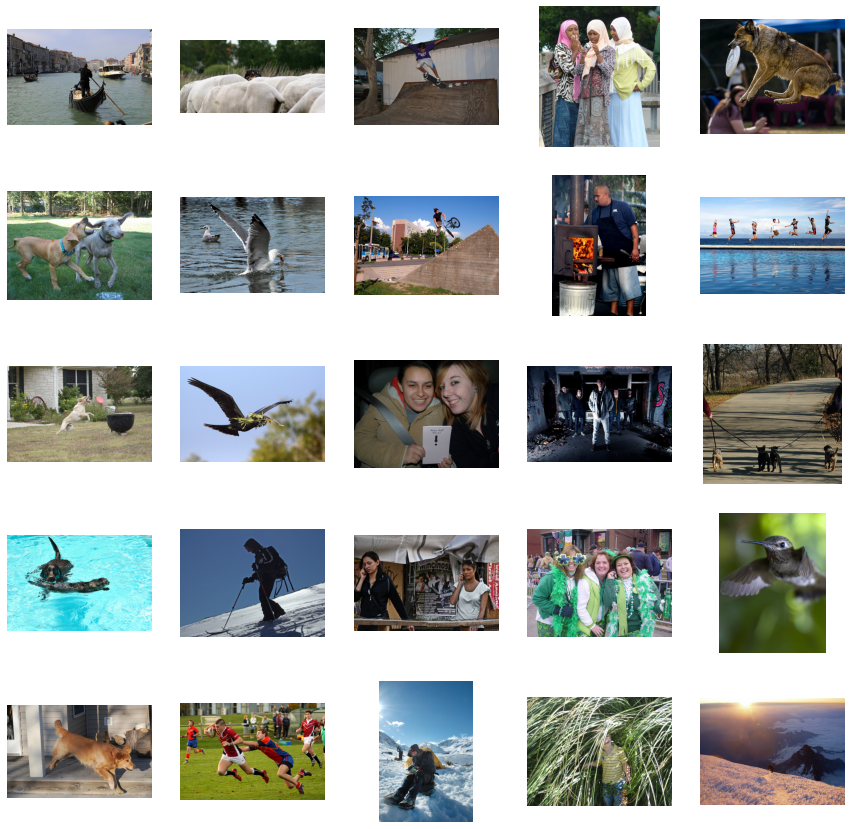

In [13]:
n_samples = 5*5
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)

fig = plt.figure(figsize=(15, 15))

columns = 5
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

Next, we would like to view a sample image and its accompanying captions.

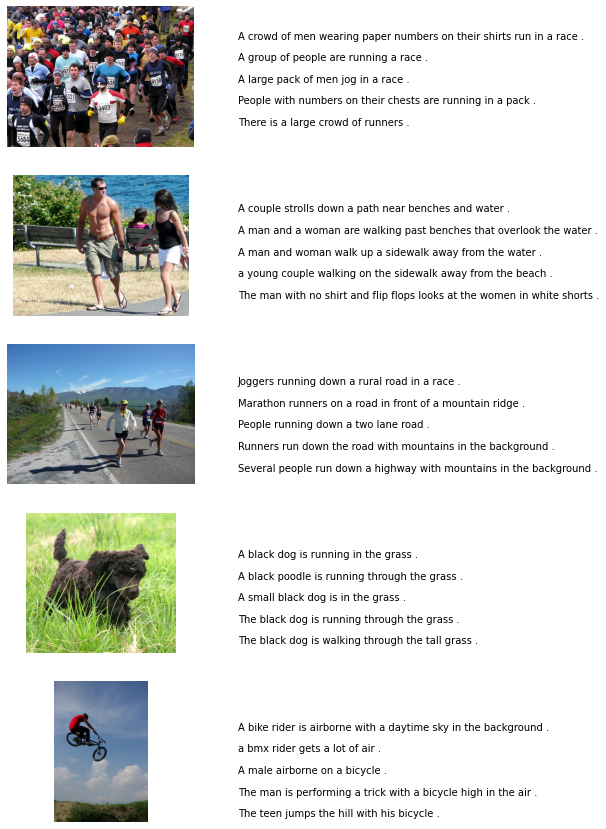

In [14]:
n_samples = 5
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)

sample_images_captions = {i:captions[captions["image"] == i]["caption"].values for i in sample_images_name}

fig = plt.figure(figsize=(8, 15))

columns = 1
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')
  for enum, caption in enumerate(sample_images_captions[sample_images_name[i]]):
    plt.figtext(0.75,0.85+i*-0.16-0.02*enum, caption)

### Image Data Preparation

We first split the images into train and validation data. The same image should not be present in both training and validation data sets. To ensure this, we will split the training and test sets by unique image names.

In [15]:
unique_image_names = list(set(captions["image"].values))

random.seed(RANDOM_STATE)
train_image_names = random.sample(unique_image_names, int(len(unique_image_names)*TRAIN_SIZE))
test_image_names = [image for image in unique_image_names if image not in train_image_names]

train_captions = captions[captions['image'].isin(train_image_names)]
test_captions = captions[captions['image'].isin(test_image_names)]

print(f"Train Images: {len(train_image_names)}")
print(f"Test Images: {len(test_image_names)}")

print(f"Train Captions: {train_captions.shape[0]}")
print(f"Test Captions: {test_captions.shape[0]}")

Train Images: 6472
Test Images: 1619
Train Captions: 32360
Test Captions: 8095


### Image Feature Extraction

In this section, we will extract the features of each image using 2 pre-trained models:
1. YoloV5 for object detection and
2. VGG16 for object classification

#### Yolov5

In [16]:
yolov5_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5n - yolov5x6, custom


  "You are about to download and run code from an untrusted repository. In a future release, this won't "

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-11-7 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)



[Errno 2] No such file or directory: '/usr/local/lib/python3.7/dist-packages/urllib3-1.24.3.dist-info/METADATA'


  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Demonstrating Yolov5 in object detection and classification

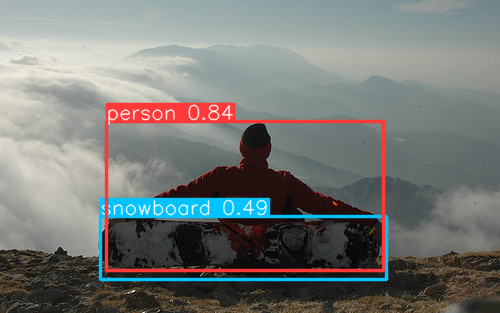

In [17]:
n_samples = 1
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)
sample_image = sample_images_path[0]

sample_results = yolov5_model(sample_image)
sample_results.show()

In [18]:
def generate_yolov5_seed_text(results):
  return " ".join([f"{v} {k}" for k,v in dict(Counter(results.pandas().xyxy[0]['name'])).items()])

def yolov5_predict(image_path, convert_to_path = False):
  if convert_to_path:
    image_path = f"{drive_path}data/flickr_8k_dataset/Images/{image_path}"
  result = yolov5_model(image_path)
  return generate_yolov5_seed_text(result)

In [19]:
generate_yolov5_seed_text(sample_results)

'1 person 1 snowboard'

In [20]:
# image_df = pd.DataFrame(unique_image_names).rename(columns={0:"image"})
train_image_df = pd.DataFrame(train_image_names).rename(columns={0:"image"})
test_image_df = pd.DataFrame(test_image_names).rename(columns={0:"image"})

In [21]:
train_image_df["yolov5_pred"] = train_image_df["image"].apply(lambda img: yolov5_predict(img, convert_to_path = True))
test_image_df["yolov5_pred"] = test_image_df["image"].apply(lambda img: yolov5_predict(img, convert_to_path = True))

### VGG16

In [22]:
def transform_image(image_path):
  image = Image.open(image_path)
  image = image.resize((224,224))
  x = transforms.functional.to_tensor(image)
  x.unsqueeze_(0)
  x=x.to(DEVICE)
  return x

In [23]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt


--2022-11-07 18:35:19--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-11-07 18:35:19 (106 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [24]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [25]:
# Setting up the vgg16 model for transfer learning

vgg16 = models.vgg16_bn(weights="IMAGENET1K_V1").to(DEVICE)
print(f"Number of predicted features: {vgg16.classifier[6].out_features}")

# We freeze training for all layers in the vgg16 model

for param in vgg16.features.parameters():
    param.require_grad = False

# View layers in the VGG16 Model
summary(vgg16, (3, 224, 224))  

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Number of predicted features: 1000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
    

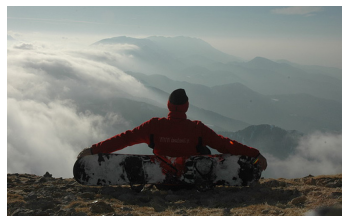

In [26]:
show_image(sample_image)

In [27]:
vgg16_sample_image = transform_image(sample_image)

In [28]:
VGG_16_prediction=vgg16(vgg16_sample_image)
VGG_16_prediction_numpy=VGG_16_prediction.cpu().detach().numpy()
predicted_class_max = np.argmax(VGG_16_prediction_numpy)
categories[predicted_class_max]                                               

'television'

In [29]:
def vgg16_predict(image_path, convert_to_path = False):
  if convert_to_path:
    image_path = f"{drive_path}data/flickr_8k_dataset/Images/{image_path}"
  image = transform_image(image_path)
  VGG_16_prediction=vgg16(image)
  VGG_16_prediction_numpy=VGG_16_prediction.cpu().detach().numpy()
  predicted_class_max = np.argmax(VGG_16_prediction_numpy)
  return categories[predicted_class_max]  

In [30]:
train_image_df["vgg16_pred"] = train_image_df["image"].apply(lambda img: vgg16_predict(img, convert_to_path = True))
test_image_df["vgg16_pred"] = test_image_df["image"].apply(lambda img: vgg16_predict(img, convert_to_path = True))

In [31]:
train_image_df

,image,yolov5_pred,vgg16_pred
0,2531531628_b4a5041680.jpg,1 person,potter's wheel
1,436015762_8d0bae90c3.jpg,1 person,vacuum
2,3248352729_ab264b2222.jpg,1 person 1 snowboard,sombrero
3,456299217_b2802efbc2.jpg,5 person 1 skateboard,canoe
4,2561334141_0aacefa5e7.jpg,1 sports ball 1 person 1 dog 1 frisbee,Chihuahua
...,...,...,...
6467,746787916_ceb103069f.jpg,1 dog 1 person,rain barrel
6468,2746839158_4195210d27.jpg,3 person,umbrella
6469,835415474_7b7f2a9768.jpg,1 person,bucket
6470,3399843227_3b9d2a8dbf.jpg,1 bowl 4 person,binoculars


In [32]:
test_image_df

,image,yolov5_pred,vgg16_pred
0,247691240_3881777ab8.jpg,1 person,plunger
1,498957941_f0eda42787.jpg,1 person,tricycle
2,3620492762_7f6a9b4746.jpg,1 motorcycle 1 person,whippet
3,2194286203_5dc620006a.jpg,2 person,guinea pig
4,3587449716_3bf1552c36.jpg,4 person 1 backpack 1 cell phone,vacuum
...,...,...,...
1614,33108590_d685bfe51c.jpg,3 person 1 bowl 2 bottle 1 potted plant,television
1615,2169067981_cc19268f23.jpg,3 person 3 chair,toaster
1616,1032460886_4a598ed535.jpg,1 person,barrow
1617,3338291921_fe7ae0c8f8.jpg,1 dog 1 frisbee,bucket


In [33]:
train_df = train_captions.merge(train_image_df, on="image")
train_df['seed_words'] = train_df['yolov5_pred'] + " " + train_df['vgg16_pred']
train_df

,image,caption,yolov5_pred,vgg16_pred,seed_words
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,1 person 1 vase,tricycle,1 person 1 vase tricycle
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,1 person 1 vase,tricycle,1 person 1 vase tricycle
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,1 person 1 vase,tricycle,1 person 1 vase tricycle
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,1 person 1 vase,tricycle,1 person 1 vase tricycle
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,1 person 1 vase,tricycle,1 person 1 vase tricycle
...,...,...,...,...,...
32355,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,1 person 1 bear,television,1 person 1 bear television
32356,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,1 person 1 bear,television,1 person 1 bear television
32357,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,1 person 1 bear,television,1 person 1 bear television
32358,997722733_0cb5439472.jpg,A rock climber in a red shirt .,1 person 1 bear,television,1 person 1 bear television


In [34]:
test_df = test_captions.merge(test_image_df, on="image")
test_df['seed_words'] = test_df['yolov5_pred'] + " " + test_df['vgg16_pred']
test_df

,image,caption,yolov5_pred,vgg16_pred,seed_words
0,1015118661_980735411b.jpg,A boy smiles in front of a stony wall in a city .,2 person 1 cat 1 potted plant,paintbrush,2 person 1 cat 1 potted plant paintbrush
1,1015118661_980735411b.jpg,A little boy is standing on the street while a...,2 person 1 cat 1 potted plant,paintbrush,2 person 1 cat 1 potted plant paintbrush
2,1015118661_980735411b.jpg,A young boy runs aross the street .,2 person 1 cat 1 potted plant,paintbrush,2 person 1 cat 1 potted plant paintbrush
3,1015118661_980735411b.jpg,A young child is walking on a stone paved stre...,2 person 1 cat 1 potted plant,paintbrush,2 person 1 cat 1 potted plant paintbrush
4,1015118661_980735411b.jpg,Smiling boy in white shirt and blue jeans in f...,2 person 1 cat 1 potted plant,paintbrush,2 person 1 cat 1 potted plant paintbrush
...,...,...,...,...,...
8090,977856234_0d9caee7b2.jpg,A brown dog in a pink shirt runs through a fie...,1 dog,comic book,1 dog comic book
8091,977856234_0d9caee7b2.jpg,A hairy dog with a pink shirt running through ...,1 dog,comic book,1 dog comic book
8092,977856234_0d9caee7b2.jpg,A long-haired dog wearing a pink vest and running,1 dog,comic book,1 dog comic book
8093,977856234_0d9caee7b2.jpg,Brown dog in a pink sweater runs on yellow gra...,1 dog,comic book,1 dog comic book


### Training Captions Pre-processing

#### Tokenisation

In [35]:
# control verbosity
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# define support functions
def load_glove_vectors(filename = "glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

In [36]:
# prepare data for the later cells
glove_vocabulary, glove_vectors = load_glove_vectors()
rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

# add special tokens
special_tokens = ['<|start|>', '<|unknown|>', '<|pad|>']
glove_vocabulary = special_tokens + glove_vocabulary
glove_vectors = torch.cat([torch.randn_like(glove_vectors[:len(special_tokens)]), glove_vectors])

# tokenizer for GloVe
glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)}, unk_token="<|unknown|>"))
glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

Downloading:   0%|          | 0.00/862M [00:00<?, ?B/s]

Parsing glove.6B.300d.txt...:   0%|          | 0/400001 [00:00<?, ?it/s]

glove_vocabulary: type=<class 'list'>, length=400001

glove_vectors: type=<class 'torch.Tensor'>, shape=torch.Size([400001, 300]), dtype=torch.float32

In [37]:
train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'caption', 'yolov5_pred', 'vgg16_pred', 'seed_words'],
        num_rows: 32360
    })
    test: Dataset({
        features: ['image', 'caption', 'yolov5_pred', 'vgg16_pred', 'seed_words'],
        num_rows: 8095
    })
})

In [38]:
max_dataset_size = dataset_dict["train"].shape[0] 
max_seq_size = 10 # and very short sequences

# load and tokenizer the dataset
def batch_tokenize(batch: List[Dict[str, Any]], max_length=max_seq_size, tokenizer: tokenizers.Tokenizer = None) -> torch.Tensor:
    seed_words = batch["seed_words"]
    seed_words_encodings = tokenizer.encode_batch(seed_words)

    captions = batch["caption"]
    caption_encoding = tokenizer.encode_batch(captions)

    return {
        "seed_words_token_ids": [x.ids[:max_length] for x in seed_words_encodings],
        "captions_token_ids": [x.ids[:max_length] for x in caption_encoding],  
        }

# load AG News, take a subset of `max_dataset_size` rows and tokenize
# dataset = datasets.load_dataset("ag_news")
train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

dataset = datasets.DatasetDict({split: dset.select(range(max_dataset_size)) if len(dset) > max_dataset_size else dset for split, dset in dataset_dict.items()})
dataset = dataset.map(partial(batch_tokenize, tokenizer=glove_tokenizer), batched=True, num_proc=2, batch_size=10)
rich.print(dataset)

#0:   0%|          | 0/1618 [00:00<?, ?ba/s]

#1:   0%|          | 0/1618 [00:00<?, ?ba/s]

#0:   0%|          | 0/405 [00:00<?, ?ba/s]

#1:   0%|          | 0/405 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'caption', 'yolov5_pred', 'vgg16_pred', 'seed_words', 'seed_words_token_ids', 
'captions_token_ids'],
        num_rows: 32360
    })
    test: Dataset({
        features: ['image', 'caption', 'yolov5_pred', 'vgg16_pred', 'seed_words', 'seed_words_token_ids', 
'captions_token_ids'],
        num_rows: 8095
    })
})

In [52]:
dataset['train']['seed_words_token_ids']

[[179, 902, 179, 25429, 40704],
 [179, 902, 179, 25429, 40704],
 [179, 902, 179, 25429, 40704],
 [179, 902, 179, 25429, 40704],
 [179, 902, 179, 25429, 40704],
 [235, 2929, 217349],
 [235, 2929, 217349],
 [235, 2929, 217349],
 [235, 2929, 217349],
 [235, 2929, 217349],
 [179, 902, 179, 18199, 2909],
 [179, 902, 179, 18199, 2909],
 [179, 902, 179, 18199, 2909],
 [179, 902, 179, 18199, 2909],
 [179, 902, 179, 18199, 2909],
 [179, 2929, 179, 902, 179, 4533, 22917],
 [179, 2929, 179, 902, 179, 4533, 22917],
 [179, 2929, 179, 902, 179, 4533, 22917],
 [179, 2929, 179, 902, 179, 4533, 22917],
 [179, 2929, 179, 902, 179, 4533, 22917],
 [317, 902, 138849],
 [317, 902, 138849],
 [317, 902, 138849],
 [317, 902, 138849],
 [317, 902, 138849],
 [179, 902, 18966],
 [179, 902, 18966],
 [179, 902, 18966],
 [179, 902, 18966],
 [179, 902, 18966],
 [179, 2929, 217349],
 [179, 2929, 217349],
 [179, 2929, 217349],
 [179, 2929, 217349],
 [179, 2929, 217349],
 [179, 887, 1086, 179, 2929, 25305],
 [179, 887, 1

In [53]:
glove_vectors

tensor([[ 2.35091e+00,  6.75598e-01, -2.86848e-01,  ..., -9.67448e-01,  5.76595e-02, -4.21678e-01],
        [ 4.41659e-01,  2.01978e+00, -1.74564e+00,  ..., -4.70185e-01, -1.31700e-03, -5.60755e-01],
        [ 1.62965e+00, -3.08623e-01,  8.50294e-01,  ..., -2.42066e-01, -2.81422e-01, -1.25865e+00],
        ...,
        [ 8.14510e-01, -3.62210e-01,  3.11860e-01,  ...,  7.54860e-02,  2.84080e-01, -1.75590e-01],
        [ 4.29191e-01, -2.96897e-01,  1.50110e-01,  ...,  2.89750e-01,  3.26180e-01, -5.90532e-02],
        [ 4.29191e-01, -2.96897e-01,  1.50110e-01,  ...,  2.89750e-01,  3.26180e-01, -5.90532e-02]])

In [108]:
class RNNLM(torch.nn.Module):
    """A simple implementation of a language model using RNNs."""
    def __init__(self, vectors:torch.Tensor):
        super().__init__()
        # register the embeddings
        self.embeddings = torch.nn.Embedding(*glove_vectors.shape)
        self.embeddings.weight.data = glove_vectors

        # Number of Layers 
        self.num_layers = 1

        # register the LSTM
        self.rnn = torch.nn.LSTM(
            input_size=glove_vectors.shape[1],
            hidden_size=glove_vectors.shape[1],
            num_layers=self.num_layers,
            batch_first=True,
        )

        # project the output of the LSTM (hidden state) back to the vocabulary space
        self.proj = nn.Linear(glove_vectors.shape[1], glove_vectors.shape[0], bias=False)
        # init the projection using the embeddings weights
        self.proj.weight.data = glove_vectors

    def forward(self, token_ids: torch.Tensor, retain_ws:bool=False) -> torch.Tensor:
        # convert the tokens into vectors
        ws = self.embeddings(token_ids)

        # store the word vectors for debugging
        if retain_ws:
          ws.retain_grad()
          self.ws = ws

        # shift the input `ws` right
        w0 = torch.zeros((ws.shape[0], 1, self.embeddings.weight.shape[1]),
                         device=self.embeddings.weight.device, dtype=torch.long)
        ws_shifted = torch.cat([w0, ws[:, :-1]], dim=1)

        # call the RNN: w_{-1:T-1} -> h{1:T}
        hidden_states, _ = self.rnn(ws_shifted)

        # project the hidden state to the vocabulary space
        logits = self.proj(hidden_states)
        return logits

    def sample(
            self,
            batch_size:int=1,
            num_steps:int=10,
            temperature: float=1.0,
            prevent_repetitions: bool=False
        ):
        token_ids = torch.empty((batch_size, 0), device=self.embeddings.weight.device, dtype=torch.long)
        for t in tqdm(range(num_steps), desc=f"Sampling {num_steps} steps.."):
            logits = self.forward(token_ids)
            logits_t = logits[:, -1:] / temperature
            if prevent_repetitions and t > 0:
                # mask the last generated tokens to avoid repetitions
                logits_t.scatter_(index=token_ids[:,-1:, None], dim=2, value=-math.inf)
            p_wt = torch.distributions.Categorical(logits=logits_t)
            tokens_t = p_wt.sample()
            token_ids = torch.cat([token_ids, tokens_t], dim=1)
        return token_ids


# init RNN initialized from GloVe vectors
# delete the checkpoint if you get `PytorchStreamReader` error
checkpoint_file = Path("rrn-lm.ckpt")
rnn = RNNLM(glove_vectors)
if checkpoint_file.exists():
    # checkpoint_file.unlink() # delete the checkpoint by un-commenting this line
    rnn.load_state_dict(torch.load(checkpoint_file, map_location="cpu"))

In [109]:
import gc 

gc.collect()

# use Adam optimizer
optimiser = torch.optim.AdamW(rnn.parameters(), lr=1e-3)

# define a data loader to iterate the dataset
train_loader = torch.utils.data.DataLoader(
    dataset['train'],
    batch_size=64,
    shuffle=True,
    num_workers=2,
    collate_fn=list,
)

# convert token_ids to tensors
def make_batch(batch: List[Dict[str, Any]], max_length=24, key:str="captions_token_ids") -> torch.Tensor:
    """Collate the `token_ids` into a single tensor, pad to minimum length."""
    token_ids = [b[key] for b in batch]
    max_length = min(max_length, *(len(x) for x in token_ids))
    token_ids = [torch.tensor(x) for x in token_ids]
    return torch.stack([x[:max_length] for x in token_ids])

# If you don't have enough GPU memory, decrease the batch size, potentially along with the learning rate.
rnn = rnn.to(DEVICE)
num_steps = 100
step = 0
epoch = 0
gc.collect()
with tqdm(total=num_steps) as pbar:
    while step < num_steps:
        for batch in train_loader:
            # concatenate the `token_ids``
            batch_token_ids = make_batch(batch)
            batch_token_ids = batch_token_ids.to(DEVICE)

            # forward through the model
            optimiser.zero_grad()
            batch_logits = rnn(batch_token_ids)

            # compute the loss (negative log-likelihood)
            p_ws = torch.distributions.Categorical(logits=batch_logits) 

            # Exercise: write the loss of the RNN language model
            # hint: check the doc https://pytorch.org/docs/stable/distributions.html#categorical
            # NB: even with the right loss, training is slow and the generated samples won't be very good.
            loss = -torch.sum(p_ws.log_prob(p_ws.sample()))
            

            gc.collect()
            # backward and optimize
            loss.backward()
            optimiser.step()
            step += 1
            pbar.update(1)

            # Report
            if step % 5 ==0 :
                loss = loss.detach().cpu()
                pbar.set_description(f"epoch={epoch}, step={step}, loss={loss:.1f}")

            # save checkpoint
            if step % 50 ==0 :
                torch.save(rnn.state_dict(), checkpoint_file)
            if step >= num_steps:
                break
        epoch += 1

  0%|          | 0/100 [00:00<?, ?it/s]

In [110]:
# sample the RNN language model
with torch.no_grad():
    sample = rnn.sample(num_steps=50, batch_size=1, temperature=0.5, prevent_repetitions=True)
    rich.print(glove_tokenizer.decode_batch(sample.detach().cpu().numpy()))

Sampling 50 steps..:   0%|          | 0/50 [00:00<?, ?it/s]

[
    'crickets poreč http://thomas.loc.gov http://thomas.loc.gov/ http://thomas.loc.gov http://thomas.loc.gov/ 
http://thomas.loc.gov forewings forewing forewings forewing forewings forewing forewings forewing forewings 
forewing forewings hindwings forewings hindwings forewings forewing forewings forewing forewings hindwings 
forewings forewing forewings hindwings forewings forewing forewings forewing forewings forewing forewings forewing 
forewings forewing forewings hindwings forewings forewing forewings forewing forewings hindwings forewings'
]

In [105]:
torch.FloatTensor(dataset['train']['captions_token_ids'][:1])

tensor([[  10.,  967.,    9.,   10., 5494., 4638.,   17., 6855.,   63.,   10.]])